In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Distributions import Normal
from UQpy.SampleMethods import MCS, LHS
from UQpy.Surrogates import ErrorEstimation
from UQpy.Sensitivity import SobolGPR
import scipy.stats as stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn import preprocessing
from scipy.linalg import sqrtm

In [2]:
def exponential_cosine(x, s):
    length_scale = 3000  # Length scale in mm
    a = 1/37000
    f0 = (1/2*np.pi)*np.sqrt(a/length_scale-a**2)
    tau = abs(x - s)
    corr_matrix = np.exp(-a * tau) * np.cos(2 * np.pi * f0 * tau)
    return corr_matrix


def kle_10(y):
    if len(y.shape) == 1:
        y = y.reshape(1, -1)

    x = np.atleast_2d(np.linspace(11200, 29500, 62)).T
    cov_matrix = 100 * exponential_cosine(x, x.T)

    # kle = KLE(nsamples=None, correlation_function=cov_matrix, time_interval=30, threshold=y.shape[1])
    lam, phi = np.linalg.eig(cov_matrix)
    lam = np.diag(lam)
    lam = lam.astype(np.float64)
    val = np.zeros([y.shape[0], 1])
    for i in range(y.shape[0]):
        samples = np.dot(phi[:, :y.shape[1]], np.dot(sqrtm(lam[:y.shape[1], :y.shape[1]]), y[i, :]))
        samples = np.real(samples)
        val[i] = np.var(samples)
    return val

In [3]:
input_dimension = 10
nsamples = 250

In [4]:
x_12 = np.atleast_2d(np.linspace(11200, 29500, 62)).T
cov_matrix_ = 100 * exponential_cosine(x_12, x_12.T)

lam, phi = np.linalg.eig(cov_matrix_)
lam = lam[:input_dimension]

true_si = lam**2/np.sum(lam**2)

In [5]:
marginals = [Normal()]*input_dimension

In [6]:
lhs = LHS(dist_object=marginals, nsamples=nsamples, random_state=0)

In [7]:
samples = lhs.samples
values = np.zeros([samples.shape[0], 1])
for i_ in range(nsamples):
    values[i_, 0] = kle_10(samples[i_])


In [8]:
kernel = ConstantKernel(constant_value_bounds=(1e-2, 10)) * RBF(length_scale=[1] * input_dimension,
                                                                length_scale_bounds=(0.01, 10))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

In [9]:
training_x = samples.copy()
training_y = values.copy()
transform_x = preprocessing.StandardScaler().fit(training_x)
transform_training_x = transform_x.transform(training_x)

transform_y = preprocessing.StandardScaler().fit(training_y)
transform_training_y = transform_y.transform(training_y)

In [10]:
gpr.fit(transform_training_x, transform_training_y)
print('GPR hyperparameters: ', gpr.kernel_.k1, gpr.kernel_.k2)

GPR hyperparameters:  1.77**2 RBF(length_scale=[2.68, 2.85, 10, 10, 10, 10, 10, 10, 10, 10])


In [11]:
test_samples = MCS(dist_object=marginals, nsamples=50, random_state=1).samples
test_values = kle_10(test_samples).reshape(-1, 1)

In [12]:
# Compute Validation Error using UQpy
err = ErrorEstimation(surr_object=gpr)
print('Validation Error: ', round(err.validation(transform_x.transform(test_samples), transform_y.transform(test_values)), 4))

Validation Error:  0.0016


In [13]:
def anaylitical_int(s_t=None, d_=None, kg_=None, sam_std=None, sam_mean=None, k__=None, **kwargs):
    theta = 1/(2*kg_.kernel_.k2.length_scale[k__]**2)
    t_std = d_.moments()[1]/sam_std[k__]
    t_mu = (d_.moments()[0] - sam_mean[k__])/sam_std[k__]
    tmp1 = 1 / t_std / np.sqrt(2 * theta + t_std ** (-2))
    tmp2 = np.exp(-0.5 * (s_t - t_mu) ** 2 / (t_std ** 2 + (1 / 2 / theta)))
    return tmp1 * tmp2


def anaylitical_dbl_int(d_=None, kg_=None, sam_std=None, k__=None, **kwargs):
    theta = 1/(2*kg_.kernel_.k2.length_scale[k__]**2)
    t_std = d_.moments()[1] / sam_std[k__]
    tmp1 = 1 / t_std / np.sqrt(2 * theta + t_std ** (-2))
    tmp2 = np.sqrt((t_std ** 2 + 1 / 2 / theta) / (2 * t_std ** 2 + 1 / 2 / theta))
    return tmp1 * tmp2

In [14]:
si = SobolGPR(surr_object=gpr, dist_object=marginals, random_state=0, nrandv=400, transform_x=transform_x, 
              transform_y=transform_y, single_int=anaylitical_int, double_int=anaylitical_dbl_int)
si.run(samples=samples)

(Total variance) MCS estimate:  6666.709226025455
Sobol Indices (using MCS estimate of variance):  [0.5471809550105198, 0.39972315812782305, 0.0052395947684226235, 0.004502268741974087, 0.00039407841405339207, 0.00025914667638814073, 7.193196585368232e-05, 4.1767669059471896e-05, 1.8135216821511095e-05, 2.0987946445843647e-05]


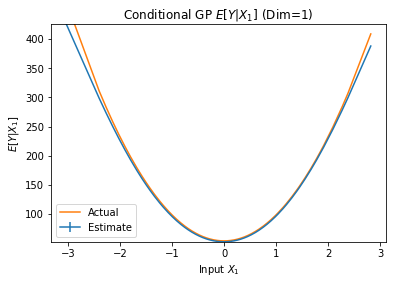

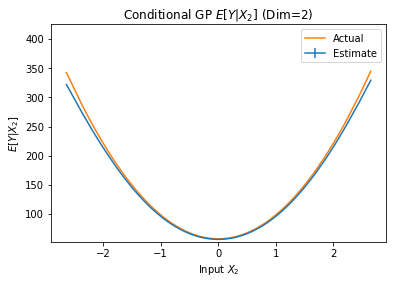

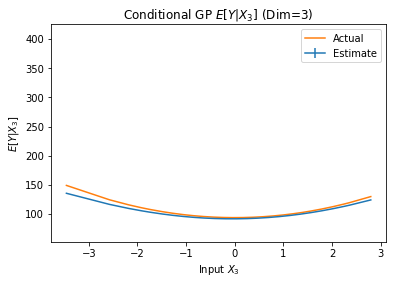

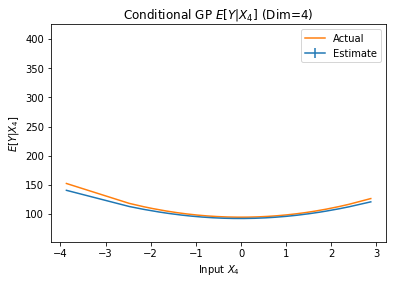

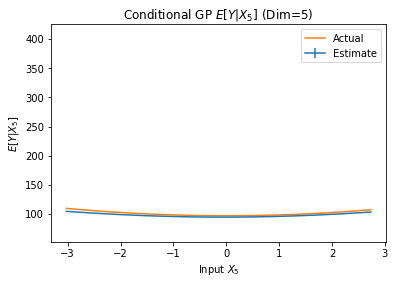

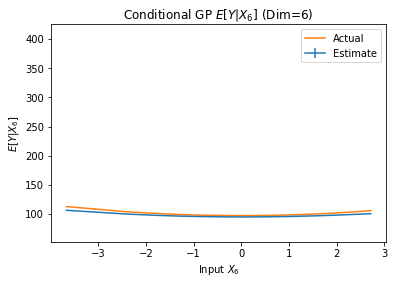

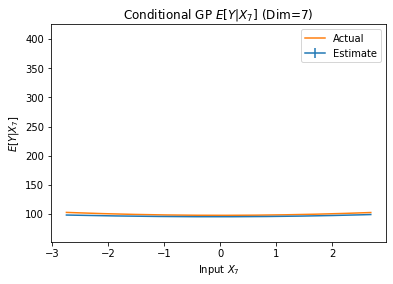

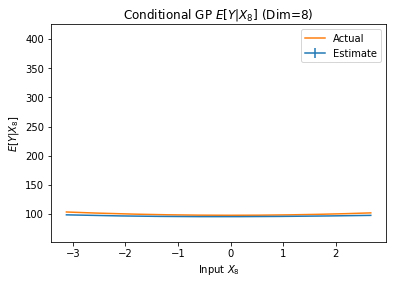

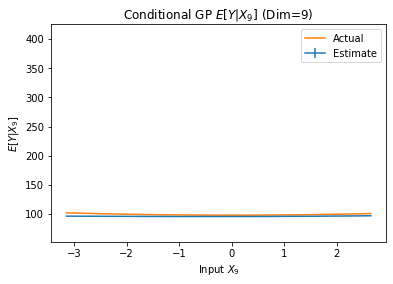

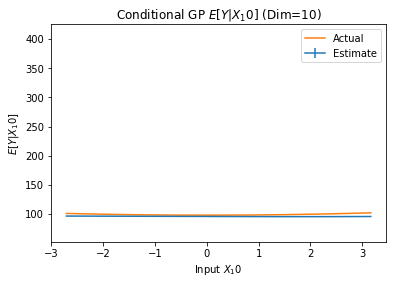

In [15]:
C = [sum(np.delete(lam, i)) for i in range(input_dimension)]

fun_10 = [lambda x: (lam[0]*x**2+C[0])/62, lambda x: (lam[1]*x**2+C[1])/62, lambda x: (lam[2]*x**2+C[2])/62, 
          lambda x: (lam[3]*x**2+C[3])/62, lambda x: (lam[4]*x**2+C[4])/62, lambda x: (lam[5]*x**2+C[5])/62, 
          lambda x: (lam[6]*x**2+C[6])/62, lambda x: (lam[7]*x**2+C[7])/62, lambda x: (lam[8]*x**2+C[8])/62, 
          lambda x: (lam[9]*x**2+C[9])/62]

si.plot_conditional_gp(actual_function=fun_10, err_bar=1)

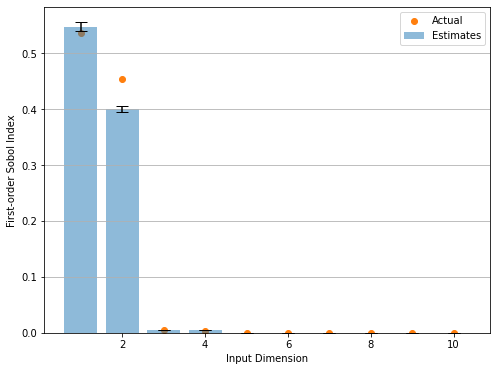

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(input_dimension)+1, si.sobol_mean, yerr=si.sobol_std, label='Estimates', capsize=6, alpha=0.5)
ax.scatter(np.arange(input_dimension)+1, true_si, label='Actual')
plt.xlabel('Input Dimension')
plt.ylabel('First-order Sobol Index')
ax.yaxis.grid(True)
plt.legend()
plt.show()

In [19]:
int_mean, s_ij_mean, s_ij_std = si.run_interaction()

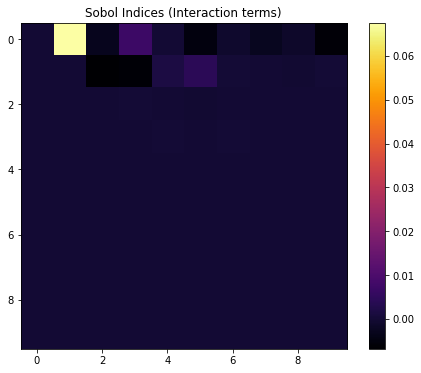

In [20]:
fig = plt.figure(figsize=(8,6))
plt.imshow(s_ij_mean, cmap="inferno")
plt.title("Sobol Indices (Interaction terms)")
plt.colorbar()
plt.show()

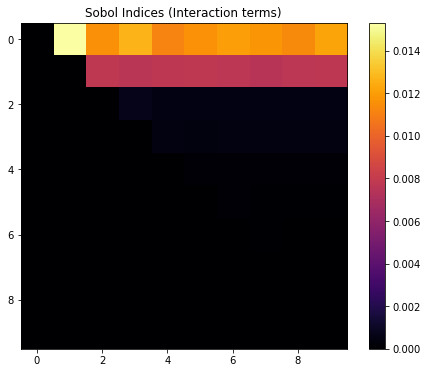

In [21]:
fig = plt.figure(figsize=(8,6))
plt.imshow(s_ij_std, cmap="inferno")
plt.title("Sobol Indices (Interaction terms)")
plt.colorbar()
plt.show()

In [24]:
s_ij_mean

array([[ 0.00000000e+00,  6.75956299e-02, -2.88164000e-03,
         7.40513216e-03, -4.89308869e-06, -4.97906638e-03,
        -9.08720493e-04, -2.72579362e-03, -1.05818799e-03,
        -5.90321879e-03],
       [ 0.00000000e+00,  0.00000000e+00, -6.82774766e-03,
        -6.21289743e-03,  1.76813791e-03,  4.38226520e-03,
         3.44637688e-04,  1.15276435e-04, -1.79273456e-04,
         2.52215511e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.27179373e-04,  5.35899293e-05, -2.75973271e-04,
         6.45999668e-05, -3.73685856e-05,  3.06963091e-05,
         1.04572670e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.97723719e-04,  1.36561907e-06,
         1.58624297e-04, -5.52372183e-05,  3.42370493e-05,
         1.74646500e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.36632215e-05,
         3.41438459e-05,  4.97514714e-05,  2.58373709e-06,
         8.